In [1]:
import sys
import os.path
import numpy as np
from landlab import imshow_grid
from landlab import RasterModelGrid
from matplotlib import pyplot as plt

#use the utility functions
utilspath=os.path.join("..","util")
sys.path = [utilspath]+sys.path
import myLandlabTools as tools

# path with topography dem data
topopath=os.path.join("..","topographies")

%matplotlib inline

In [2]:
roughnessDict = {
    'm1': [0.05],
}


# soil infiltration [min, max]
# lower value means lower infiltration
hydCondDict = {
            'inf6':[4e-6, 4.5e-6],     
            'inf7':[4.5e-6, 5e-6],     
            'inf8':[5e-6, 5.5e-6],     
            'inf9':[5.5e-6, 6e-6],        
}
# from Gowdish & Munoz                               # from Carsel & Parrish
# hydCondDict = {
#             'cond1' :[1.7e-7, 'clay'],
#             'cond2' :[2.7e-7, 'silty clay'],
#             'cond3' :[3.3e-7, 'sandy clay'],
#             'cond4' :[5.5e-7, 'silty clay loam'],
#             'cond5' :[5.5e-7, 'clay loam'],          # 7.17e-7
#             'cond6' :[8.3e-7, 'sandy clay loam'],
#             'cond7' :[1.8e-6, 'silt loam' ],         # 1.25e-6
#             'cond8' :[3.6e-6, 'loam'],               # 2.88e-6
#             'cond9' :[6.1e-6, 'sandy loam' ],        # 1.23e-5 
#             'cond10':[1.6e-5, 'loamy sand'],      
#             'cond11':[6.5e-5, 'sand' ],              # 8.25e-5  
# }

soilType = ['sandy loam']

# Water column height above the surface previously absorbed into the soil.
# Do NOT set to zero
soilWaterInfiltrationDepth = 0.15
    
dem = 'clipped2cropped2.asc'
boundary = 'noData'   
noDataValue = -99999
outletNode = 3242
monitorLink = 6352 
showProgress = False
showPlots = False   

# The dash list is a even size list that gives the ink on, ink off in pixels.
dashList = [(3,0),(1,1),(3,3),(7,7),(7,2),(5,2,2,2,5,2),(2,2,7,2,2,2),(3,3,2,2),(5,2,10,2),(10,5,20,5)] 



Storm 1995-11-18:
d=0.150|4.000e-06->4.500e-06|m=0.050|Max discharge at outlet = 19.945 m3/s
d=0.150|4.500e-06->5.000e-06|m=0.050|Max discharge at outlet = 17.385 m3/s
d=0.150|5.000e-06->5.500e-06|m=0.050|Max discharge at outlet = 14.370 m3/s
d=0.150|5.500e-06->6.000e-06|m=0.050|Max discharge at outlet = 11.842 m3/s

Storm 1997-03-11:
d=0.150|4.000e-06->4.500e-06|m=0.050|Max discharge at outlet = 23.353 m3/s
d=0.150|4.500e-06->5.000e-06|m=0.050|Max discharge at outlet = 19.402 m3/s
d=0.150|5.000e-06->5.500e-06|m=0.050|Max discharge at outlet = 13.321 m3/s
d=0.150|5.500e-06->6.000e-06|m=0.050|Max discharge at outlet = 7.426 m3/s

Storm 2009-02-10:
d=0.150|4.000e-06->4.500e-06|m=0.050|Max discharge at outlet = 28.233 m3/s
d=0.150|4.500e-06->5.000e-06|m=0.050|Max discharge at outlet = 25.115 m3/s
d=0.150|5.000e-06->5.500e-06|m=0.050|Max discharge at outlet = 21.809 m3/s
d=0.150|5.500e-06->6.000e-06|m=0.050|Max discharge at outlet = 19.123 m3/s

Storm 2010-12-08:
d=0.150|4.000e-06->4.500e

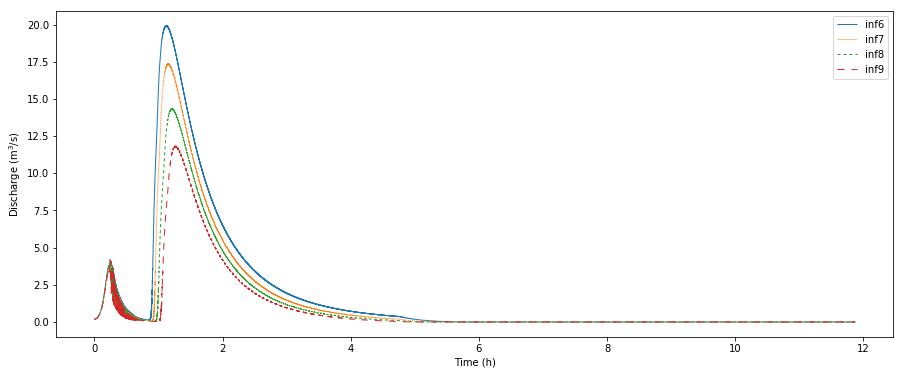

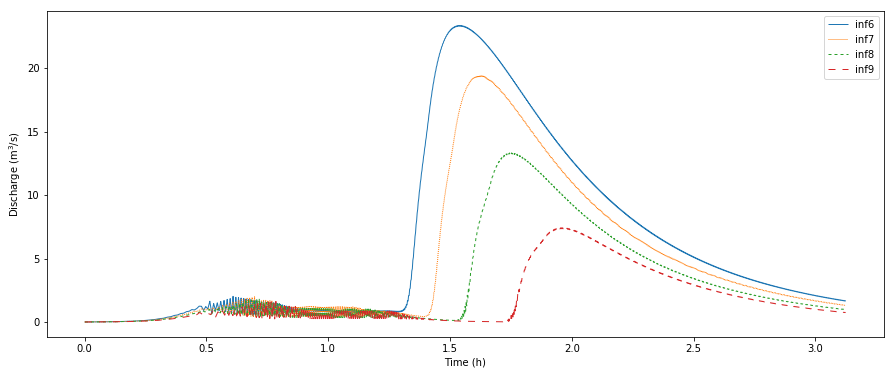

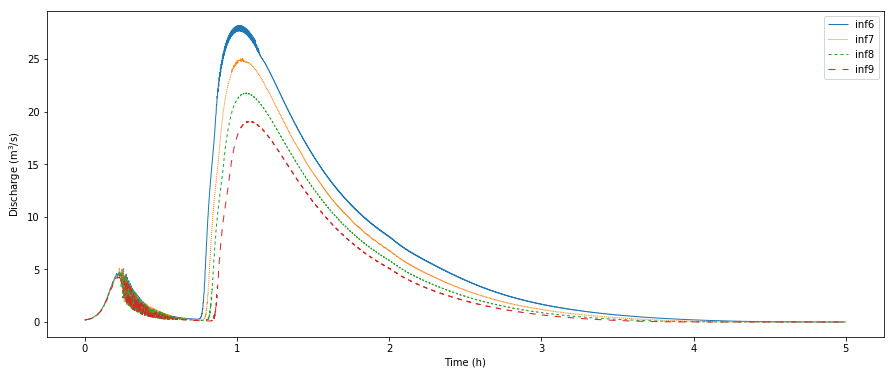

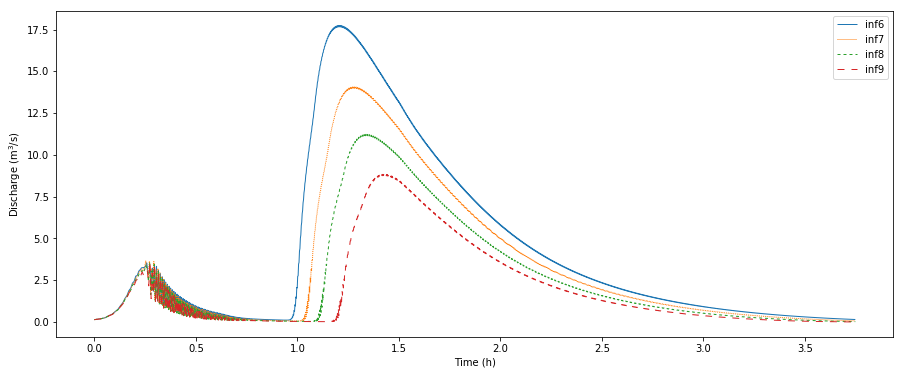

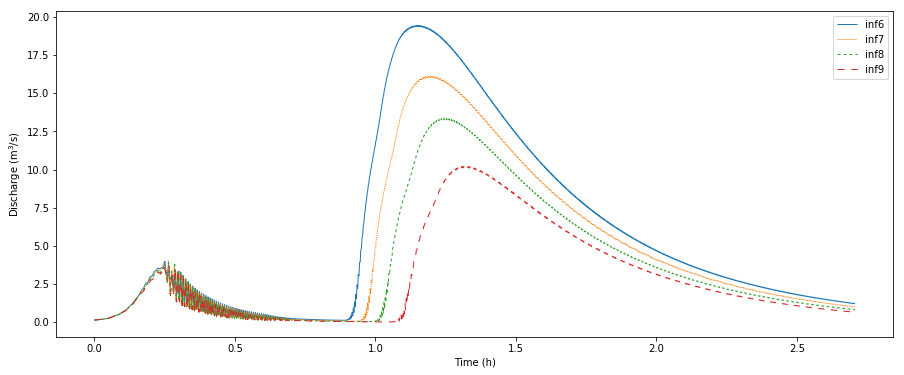

In [3]:
for i, storm_flag in enumerate(['1995-11-18','1997-03-11','2009-02-10','2010-12-08','2012-11-24']):
   
    print('\nStorm {}:'.format(storm_flag))
    
    if storm_flag == '1995-11-18':
        starting_precip_mmhr = 15.6
        starting_precip_ms = starting_precip_mmhr * (2.77778 * 10 ** -7)
        storm_duration = 17100.
        surfaceWaterDepth = 0.02
    elif storm_flag == '1997-03-11':
        starting_precip_mmhr = 34.8
        starting_precip_ms = starting_precip_mmhr * (2.77778 * 10 ** -7)
        storm_duration = 4500.
        surfaceWaterDepth = 0.003
    elif storm_flag == '2009-02-10':
        starting_precip_mmhr = 18.
        starting_precip_ms = starting_precip_mmhr * (2.77778 * 10 ** -7)
        storm_duration = 7200.
        surfaceWaterDepth = 0.022
    elif storm_flag == '2010-12-08':
        starting_precip_mmhr = 16.8
        starting_precip_ms = starting_precip_mmhr * (2.77778 * 10 ** -7)
        storm_duration = 5400.
        surfaceWaterDepth = 0.018
    elif storm_flag == '2012-11-24':
        starting_precip_mmhr = 16.8
        starting_precip_ms = starting_precip_mmhr * (2.77778 * 10 ** -7)
        storm_duration = 3900.
        surfaceWaterDepth = 0.019
    
    runHours = 2.5 * storm_duration/3600.  
    reportInterval = runHours / 4.
    
    plt.figure(i+1,figsize = (15,6))
    theLegend = []
    
    for soil_type in soilType:

        # for each hydraulic conductivity
        for m, hyd in enumerate(hydCondDict):
            min_h = hydCondDict[hyd][0]
            max_h = hydCondDict[hyd][1]

            # for each roughness value 
            for key in roughnessDict:
                mannings_n = roughnessDict[key][0]

                rmg, hydraulic_conductivity, discharge_at_outlet, hydrograph_time, h, d = tools.runModel(
                                        topopath, dem, 
                                        soil_type, min_h, max_h, 
                                        starting_precip_mmhr, storm_duration, 
                                        soilWaterInfiltrationDepth, surfaceWaterDepth,
                                        mannings_n,
                                        boundary, monitorLink,  
                                        runHours, reportInterval,
                                        soilInf = True, sinkFiller = False, 
                                        showProgress = False, showPlots = False,
                                        noDataValue=noDataValue)

                print('d={:.3f}|{:.3e}->{:.3e}|m={:.3f}|Max discharge at outlet = {:.3f} m3/s'.format(soilWaterInfiltrationDepth, min_h, max_h, mannings_n, max(discharge_at_outlet)))
                
                # Hydrograph at the outlet node
                theLegend.append(hyd)
                plt.plot(hydrograph_time, discharge_at_outlet, linewidth=1, dashes=dashList[m])
                
            plt.legend(theLegend) 
            plt.xlabel('Time (h)')
            plt.ylabel('Discharge (m$^3$/s)')
            # plt.savefig('hydrograph.png', dpi=300)

